# Credit Card Fraud Detection

## Download dataset

In [1]:
!gdown 1NwikiUU_Yzom-l4Kwy24Cn-bG46gMmG4

Downloading...
From (original): https://drive.google.com/uc?id=1NwikiUU_Yzom-l4Kwy24Cn-bG46gMmG4
From (redirected): https://drive.google.com/uc?id=1NwikiUU_Yzom-l4Kwy24Cn-bG46gMmG4&confirm=t&uuid=bd1df754-16c7-4beb-9451-0d9bf684bc94
To: /content/creditcard.csv
100% 151M/151M [00:04<00:00, 31.9MB/s]


## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Read dataset

In [3]:
dataset_path = '/content/creditcard.csv'
df = pd.read_csv(dataset_path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Split to X, y

In [4]:
dataset_arr = df.to_numpy()
X, y = dataset_arr[:, :-1].astype(np.float64), dataset_arr[:, -1].astype(np.uint8)

## Add bias to X

In [5]:
intercept = np.ones((X.shape[0], 1))

X_b = np.concatenate((intercept, X), axis=1)

## One-hot encoding label

In [6]:
n_classes = np.unique(y, axis=0).shape[0]
n_samples = y.shape[0]

y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])

y_encoded[np.arange(n_samples), y] = 1

## Split to train, val, test

In [7]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

## Normalize data

In [8]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

## Define functions

In [14]:
def softmax(z):
  exp_z = np.exp(z)

  return exp_z / exp_z.sum(axis=1)[:, None]


def predict(X, theta):
  z = np.dot(X, theta)
  y_hat = softmax(z)

  return y_hat


def compute_loss(y_hat, y):
  n = y.size

  return (-1/n) * np.sum(y * np.log(y_hat))


def compute_gradient(X, y, y_hat):
  n = y.size

  return np.dot(X.T, (y_hat - y)) / n


def update_theta(theta, gradient, lr):
  return theta - lr * gradient


def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta)

  acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()

  return acc

## Declare hyperparameters and initialize weights

In [15]:
lr = 0.01
epochs = 30
batch_size = 1024
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

## Train model

In [16]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_batch_accs = []
  train_batch_losses = []
  val_batch_accs = []
  val_batch_losses = []

  for i in range(0, X_train.shape[0], batch_size):
    X_i = X_train[i:i+batch_size]
    y_i = y_train[i:i+batch_size]

    y_hat = predict(X_i, theta)

    train_loss = compute_loss(y_hat, y_i)
    train_batch_losses.append(train_loss)

    gradient = compute_gradient(X_i, y_i, y_hat)

    theta = update_theta(theta, gradient, lr)

    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_losses.append(train_batch_loss)
  val_losses.append(val_batch_loss)
  train_accs.append(train_batch_acc)
  val_accs.append(val_batch_acc)

  print (f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.300	Validation loss: 0.297

EPOCH 2:	Training loss: 0.176	Validation loss: 0.174

EPOCH 3:	Training loss: 0.115	Validation loss: 0.113

EPOCH 4:	Training loss: 0.081	Validation loss: 0.080

EPOCH 5:	Training loss: 0.062	Validation loss: 0.061

EPOCH 6:	Training loss: 0.049	Validation loss: 0.049

EPOCH 7:	Training loss: 0.041	Validation loss: 0.041

EPOCH 8:	Training loss: 0.035	Validation loss: 0.035

EPOCH 9:	Training loss: 0.031	Validation loss: 0.031

EPOCH 10:	Training loss: 0.028	Validation loss: 0.027

EPOCH 11:	Training loss: 0.025	Validation loss: 0.025

EPOCH 12:	Training loss: 0.023	Validation loss: 0.023

EPOCH 13:	Training loss: 0.021	Validation loss: 0.021

EPOCH 14:	Training loss: 0.020	Validation loss: 0.020

EPOCH 15:	Training loss: 0.019	Validation loss: 0.018

EPOCH 16:	Training loss: 0.017	Validation loss: 0.017

EPOCH 17:	Training loss: 0.017	Validation loss: 0.016

EPOCH 18:	Training loss: 0.016	Validation loss: 0.015

EPOCH 19:	Training

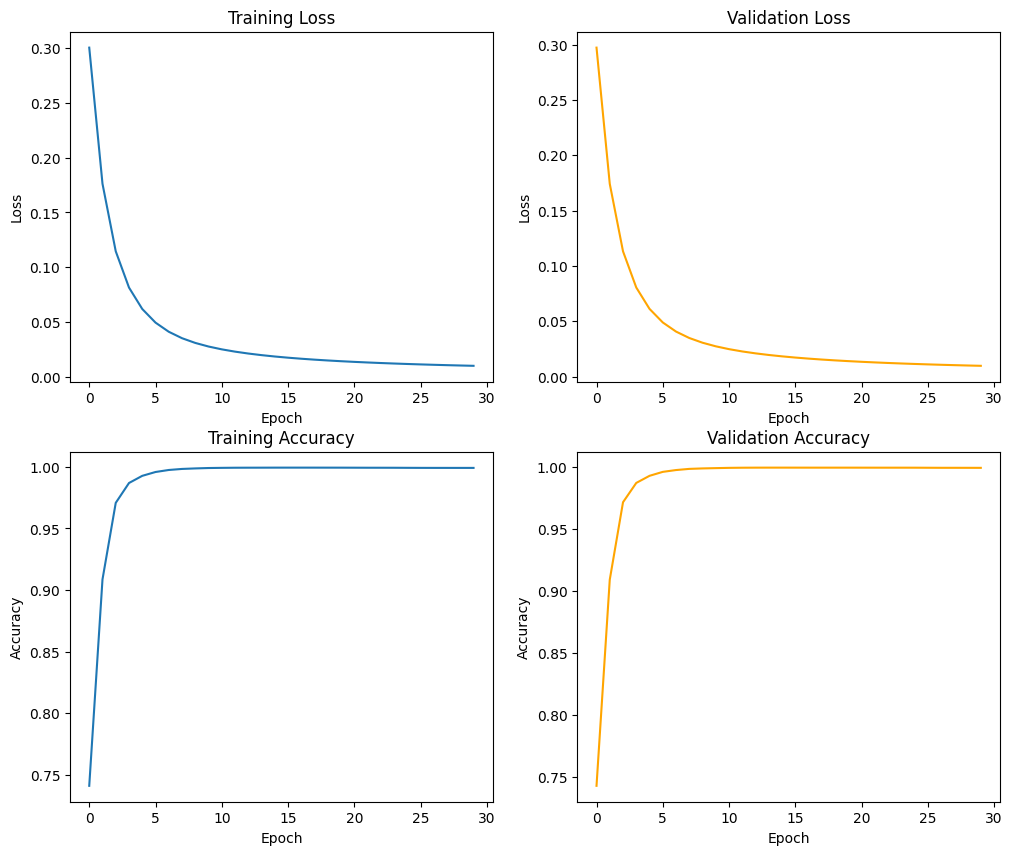

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## Validate model

In [18]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set :')
print(f'Accuracy: {val_set_acc}')
print(f'Accuracy: {test_set_acc}')

Evaluation on validation and test set :
Accuracy: 0.9993153330290369
Accuracy: 0.9992275552122467


# Twitter Sentiment Analysis

## Download dataset

In [1]:
!gdown 1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt

Downloading...
From: https://drive.google.com/uc?id=1GR3IwbvKNuiVXN5E5eMGyEQtT4pP7kCt
To: /content/Twitter_Data.csv
100% 20.9M/20.9M [00:00<00:00, 29.5MB/s]


## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Read dataset

In [3]:
dataset_path = '/content/Twitter_Data.csv'
df = pd.read_csv(dataset_path)

df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


## Delete missing data

In [4]:
df = df.dropna()

## Preprocessing dataset

In [5]:
def text_normalize(text):
  # Lowercasing
  text = text.lower

  # Retweet old acronym "RT" removal
  text = re.sub(r'^RT[\s]+', '', text)

  # Hyperlinks removal
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  # Punctuation removal
  text = re.sub(r'[^\w\s]', '', text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  words = text.split()
  words = [word for word in words if word not in stop_words]
  text = ' '.join(words)

  # Stemming
  stemmer = SnowballStemmer('english')
  words = text.split()
  words = [stemmer.stem(word) for word in words]
  text = ' '.join(words)

  return text

In [6]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

In [7]:
intercept = np.ones((X.shape[0], 1))

X_b = np.concatenate((intercept, X), axis=1)

## One-hot encoding label

In [8]:
n_classes = df['category'].nunique()
n_samples = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for _ in range(n_samples)])
y_encoded[np.arange(n_samples), y] = 1

## Split to train, val, test

In [9]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y_encoded,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

## Define functions

In [10]:
def softmax(z):
  exp_z = np.exp(z)

  return exp_z / exp_z.sum(axis=1)[:, None]


def predict(X, theta):
  z = np.dot(X, theta)
  y_hat = softmax(z)

  return y_hat


def compute_loss(y_hat, y):
  n = y.size

  return (-1/n) * np.sum(y * np.log(y_hat))


def compute_gradient(X, y, y_hat):
  n = y.size

  return np.dot(X.T, (y_hat - y)) / n


def update_theta(theta, gradient, lr):
  return theta - lr * gradient


def compute_accuracy(X, y, theta):
  y_hat = predict(X, theta)

  acc = (np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)).mean()

  return acc

## Declare hyperparameters and initializer weights

In [11]:
lr = 0.01
epochs = 30
batch_size = 1024
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

## Train model

In [12]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
  train_batch_accs = []
  train_batch_losses = []
  val_batch_accs = []
  val_batch_losses = []

  for i in range(0, X_train.shape[0], batch_size):
    X_i = X_train[i:i+batch_size]
    y_i = y_train[i:i+batch_size]

    y_hat = predict(X_i, theta)

    train_loss = compute_loss(y_hat, y_i)
    train_batch_losses.append(train_loss)

    gradient = compute_gradient(X_i, y_i, y_hat)

    theta = update_theta(theta, gradient, lr)

    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_losses.append(train_batch_loss)
  val_losses.append(val_batch_loss)
  train_accs.append(train_batch_acc)
  val_accs.append(val_batch_acc)

  print (f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.377	Validation loss: 0.377

EPOCH 2:	Training loss: 0.374	Validation loss: 0.373

EPOCH 3:	Training loss: 0.371	Validation loss: 0.371

EPOCH 4:	Training loss: 0.369	Validation loss: 0.369

EPOCH 5:	Training loss: 0.368	Validation loss: 0.367

EPOCH 6:	Training loss: 0.366	Validation loss: 0.366

EPOCH 7:	Training loss: 0.365	Validation loss: 0.364


KeyboardInterrupt: 

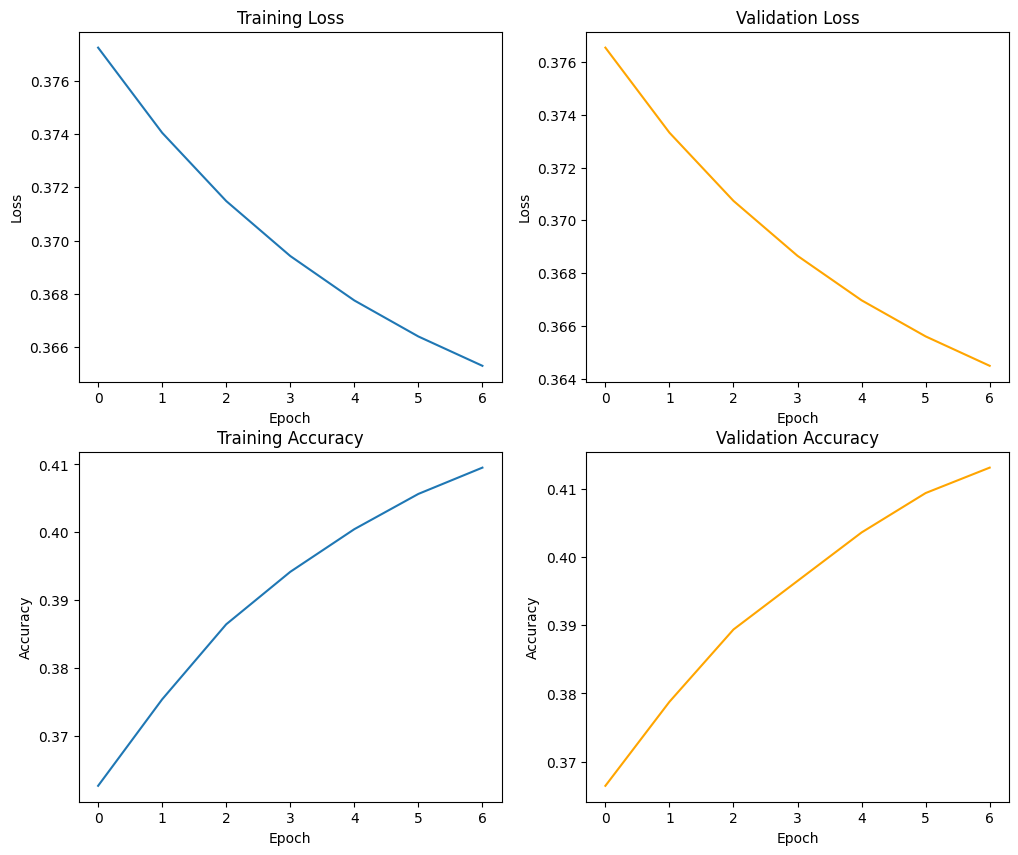

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

## Validate model

In [14]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set :')
print(f'Accuracy: {val_set_acc}')
print(f'Accuracy: {test_set_acc}')

Evaluation on validation and test set :
Accuracy: 0.41611953120206174
Accuracy: 0.40897097625329815
